In [181]:
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data.distributed
import torchvision.transforms as transforms
import os
import sys
sys.path.append('../')

import skimage.io as io

from src.helper_functions.helper_functions import mAP, AverageMeter, CocoDetection
from src.models import create_model
import numpy as np
import matplotlib.pyplot as plt
import pylab
import cv2

In [296]:
MODEL_NAME = 'resnet18'
MODEL_PATH = '../coco_tagging/resnet18/model-highest.ckpt'
# MODEL_PATH = '../coco_tagging/resnet50/model-highest.ckpt'
# MODEL_PATH = '../coco_tagging/resnet101/model-highest.ckpt'

# MODEL_NAME = 'deit_small_patch16_224'
# MODEL_PATH = '../coco_tagging/deit_small/model-highest.ckpt'
# MODEL_PATH = '../coco_tagging/deit_tiny/model-highest.ckpt'


DATA_PATH = '/mnt/nfs/datasets/coco2014/'

class args():
    data = DATA_PATH
    model_name = MODEL_NAME
    model_path = MODEL_PATH
    num_classes = 80
    workers = 8
    image_size = 448
    thre = 0.8
    batch_size = 32
    print_freq = 64
    drop = 0.0
    drop_path = 0.2
    
    threshold = 0.6 # prediction threshold

In [297]:
print('creating and loading the model...')
state = torch.load(args.model_path, map_location='cpu')

# args.num_classes = state['num_classes']
args.do_bottleneck_head = False
model = create_model(args)
model = nn.DataParallel(model).cuda()
model.load_state_dict(state['state_dict'], strict=True)
model.eval()
# classes_list = np.array(list(state['idx_to_class'].values()))
print('done\n')

creating and loading the model...
torchvision models: 
 ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'googlenet', 'inception_v3', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'wide_resnet101_2', 'wide_resnet50_2']
Vision Transformer models: 
 ['deit_tiny_patch16_224', 'deit_small_patch16_224', 'deit_base_patch16_224']
done



#### helper funtion

In [298]:
def validate_multi(val_loader, model, args):
    print("starting actuall validation")
    batch_time = AverageMeter()
    prec = AverageMeter()
    rec = AverageMeter()
    mAP_meter = AverageMeter()

    Sig = torch.nn.Sigmoid()

    end = time.time()
    tp, fp, fn, tn, count = 0, 0, 0, 0, 0
    preds = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            output = Sig(model(input.cuda())).cpu()

        # for mAP calculation
        preds.append(output.cpu())
        targets.append(target.cpu())

        # measure accuracy and record loss
        pred = output.data.gt(args.thre).long()

        tp += (pred + target).eq(2).sum(dim=0)
        fp += (pred - target).eq(1).sum(dim=0)
        fn += (pred - target).eq(-1).sum(dim=0)
        tn += (pred + target).eq(0).sum(dim=0)
        count += input.size(0)

        this_tp = (pred + target).eq(2).sum()
        this_fp = (pred - target).eq(1).sum()
        this_fn = (pred - target).eq(-1).sum()
        this_tn = (pred + target).eq(0).sum()

        this_prec = this_tp.float() / (
            this_tp + this_fp).float() * 100.0 if this_tp + this_fp != 0 else 0.0
        this_rec = this_tp.float() / (
            this_tp + this_fn).float() * 100.0 if this_tp + this_fn != 0 else 0.0

        prec.update(float(this_prec), input.size(0))
        rec.update(float(this_rec), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        p_c = [float(tp[i].float() / (tp[i] + fp[i]).float()) * 100.0 if tp[
                                                                             i] > 0 else 0.0
               for i in range(len(tp))]
        r_c = [float(tp[i].float() / (tp[i] + fn[i]).float()) * 100.0 if tp[
                                                                             i] > 0 else 0.0
               for i in range(len(tp))]
        f_c = [2 * p_c[i] * r_c[i] / (p_c[i] + r_c[i]) if tp[i] > 0 else 0.0 for
               i in range(len(tp))]

        mean_p_c = sum(p_c) / len(p_c)
        mean_r_c = sum(r_c) / len(r_c)
        mean_f_c = sum(f_c) / len(f_c)

        p_o = tp.sum().float() / (tp + fp).sum().float() * 100.0
        r_o = tp.sum().float() / (tp + fn).sum().float() * 100.0
        f_o = 2 * p_o * r_o / (p_o + r_o)

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Precision {prec.val:.2f} ({prec.avg:.2f})\t'
                  'Recall {rec.val:.2f} ({rec.avg:.2f})'.format(
                i, len(val_loader), batch_time=batch_time,
                prec=prec, rec=rec))
            print(
                'P_C {:.2f} R_C {:.2f} F_C {:.2f} P_O {:.2f} R_O {:.2f} F_O {:.2f}'
                    .format(mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o))

    print(
        '--------------------------------------------------------------------')
    print(' * P_C {:.2f} R_C {:.2f} F_C {:.2f} P_O {:.2f} R_O {:.2f} F_O {:.2f}'
          .format(mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o))

    mAP_score = mAP(torch.cat(targets).numpy(), torch.cat(preds).numpy())
    print("mAP score:", mAP_score)


In [ ]:
# Data loading code
normalize = transforms.Normalize(mean=[0, 0, 0],
                                 std=[1, 1, 1])

instances_path = os.path.join(args.data, 'annotations/instances_val2014.json')
data_path = os.path.join(args.data, 'images/val2014')
val_dataset = CocoDetection(data_path,
                            instances_path,
                            transforms.Compose([
                                transforms.Resize((args.image_size, args.image_size)),
                                transforms.ToTensor(),
                                normalize,
                            ]))

print("len(val_dataset)): ", len(val_dataset))
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)

# validate_multi(val_loader, model, args)


In [282]:
val_loader.dataset

Dataset CocoDetection
    Number of datapoints: 40137
    Root location: /mnt/nfs/home/hadi/data/coco/images/val2014

## pycocotools quickstart

##### Useful functions


In [283]:
# coco.catToImgs #class to list of images containing that class
# coco.annToMask ***** # annotation to mask. Super useful when we want to mask things out.

In [284]:
# display COCO categories and supercategories
coco = val_dataset.coco

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture person indoor animal accessory appliance outdoor food kitchen electronic vehicle sports


In [285]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','skateboard', 'car']);
# imgIds = coco.getImgIds(catIds=catIds ); Uncomment this to get all images containing the above classes
imgIds = coco.getImgIds(imgIds=[320461]) # A good ID
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img['id']

320461

In [286]:
# Get tensor from dataset using img['id']
# idx = val_dataset.imgID2ids[img['id']]
# val_dataset[idx][0].max()

In [287]:
# Alternatively, read directly from disk. This is useful for our masking experiments
from PIL import Image
im = Image.open('%s/images/%s/%s'%(DATA_PATH,'val2014', img['file_name']))

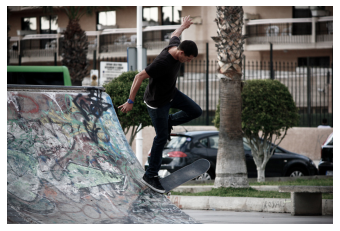

In [288]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(im)
plt.show()


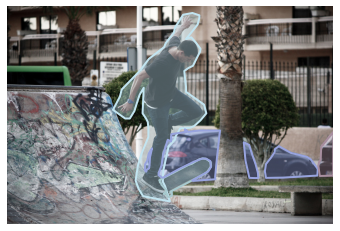

In [289]:
# load and display instance annotations
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [290]:
# im_resize = im.resize((args.image_size, args.image_size))
np_img = np.array(im_resize, dtype=np.uint8)
np_img = cv2.resize(np_img, dsize=(args.image_size, args.image_size), interpolation=cv2.INTER_CUBIC)

tensor_img = torch.from_numpy(np_img).permute(2, 0, 1).float() / 255.0  # HWC to CHW
tensor_batch = torch.unsqueeze(tensor_img, 0).cuda()
output = torch.squeeze(torch.sigmoid(model(tensor_batch)))
np_output = output.cpu().detach().numpy()

classes_list = np.array([v['name'] for v in coco.cats.values()])

detected_classes = classes_list[np_output > args.threshold].tolist()
probs = np_output[np_output > args.threshold].tolist()
result = {cls: prob for cls, prob in zip(detected_classes, probs)}
result

{'person': 0.961359977722168,
 'car': 0.6330761313438416,
 'skateboard': 0.7440875768661499}

## Now we mask out one of the classes

In [291]:
catIds # 1: person

[1, 3, 41]

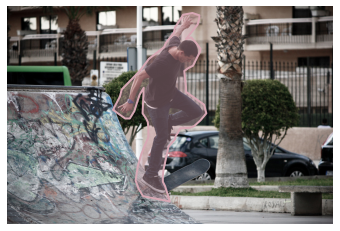

In [292]:
plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=[1], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [293]:
mask = coco.annToMask(anns[0])

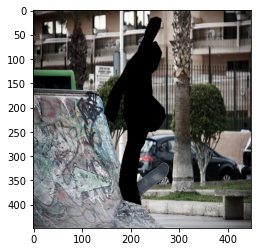

In [294]:
np_img = np.array(im, dtype=np.uint8)
np_img = np_img* (1 - mask[...,None])

np_img = cv2.resize(np_img, dsize=(args.image_size, args.image_size), interpolation=cv2.INTER_CUBIC)

plt.imshow(np_img)

In [295]:
np_img = np.array(im, dtype=np.uint8)
np_img = np_img* (1 - mask[...,None])

np_img = cv2.resize(np_img, dsize=(args.image_size, args.image_size), interpolation=cv2.INTER_CUBIC)

tensor_img = torch.from_numpy(np_img).permute(2, 0, 1).float() / 255.0  # HWC to CHW
tensor_batch = torch.unsqueeze(tensor_img, 0).cuda()
output = torch.squeeze(torch.sigmoid(model(tensor_batch)))
np_output = output.cpu().detach().numpy()

classes_list = np.array([v['name'] for v in coco.cats.values()])

detected_classes = classes_list[np_output > args.threshold].tolist()
probs = np_output[np_output > args.threshold].tolist()
result = {cls: prob for cls, prob in zip(detected_classes, probs)}
result

{'person': 0.6615127921104431,
 'car': 0.6897991895675659,
 'bird': 0.6267321705818176}